In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np

from sklearn.metrics import mean_squared_error,explained_variance_score 
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import trange
import re
import gc
pd.options.display.max_columns=50
pd.options.display.max_rows=20
import warnings


In [6]:
# baseline只用到gps定位数据，即train_gps_path
train_gps_path = 'data/clean_data1.pkl'
test_data_path = 'data/R2 ATest 0711.csv'
order_data_path = 'data/loadingOrderEvent.csv'
port_data_path = 'data/port.csv'

In [7]:
%time train_data = pd.read_pickle(train_gps_path) #读取
test_data = pd.read_csv(test_data_path)


Wall time: 13.2 s


In [8]:
train_data

,loadingOrder,carrierName,timestamp,longitude,latitude,vesselMMSI,speed,direction,vesselNextport,vesselNextportETA,vesselStatus,vesselDatasource,TRANSPORT_TRACE,diff_dist,diff_sec
0,AA191175561416,OIEQNT,2019-01-28 16:12:59+00:00,114.260392,22.571047,Y7540547327,0,12670,HK HKG >CN YTN,2019-01-28T05:30:00.000Z,moored,Coastal AIS,CNYTN-MXZLO,NaN,NaN
1,AA191175561416,OIEQNT,2019-01-28 16:22:38+00:00,114.260438,22.571125,Y7540547327,0,14790,HK HKG >CN YTN,2019-01-28T05:30:00.000Z,moored,Coastal AIS,CNYTN-MXZLO,0.009887,579.0
2,AA191175561416,OIEQNT,2019-01-28 16:30:55+00:00,114.260693,22.571567,Y7540547327,0,21510,HK HKG >CN YTN,2019-01-28T05:30:00.000Z,moored,Coastal AIS,CNYTN-MXZLO,0.055750,497.0
3,AA191175561416,OIEQNT,2019-01-28 16:37:35+00:00,114.260392,22.571463,Y7540547327,0,19900,HK HKG >CN YTN,2019-01-28T05:30:00.000Z,moored,Coastal AIS,CNYTN-MXZLO,0.033036,400.0
4,AA191175561416,OIEQNT,2019-01-28 16:45:56+00:00,114.260647,22.571510,Y7540547327,0,21360,HK HKG >CN YTN,2019-01-28T05:30:00.000Z,moored,Coastal AIS,CNYTN-MXZLO,0.026729,501.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29612150,ZZ824778274922,HMKTVZ,2020-03-04 05:14:21+00:00,136.794000,35.026833,F1868908205,5,28670,JP NGO,2020-04-03T03:00:00.000Z,under way using engine,Coastal AIS,CNSHK-JPNGO,0.161833,101.0
29612151,ZZ824778274922,HMKTVZ,2020-03-04 05:16:31+00:00,136.792333,35.027167,F1868908205,2,27440,JP NGO,2020-04-03T03:00:00.000Z,under way using engine,Coastal AIS,CNSHK-JPNGO,0.156442,130.0
29612152,ZZ824778274922,HMKTVZ,2020-03-04 05:18:31+00:00,136.791667,35.027000,F1868908205,2,22580,JP NGO,2020-04-03T03:00:00.000Z,under way using engine,Coastal AIS,CNSHK-JPNGO,0.063493,120.0
29612153,ZZ824778274922,HMKTVZ,2020-03-04 05:20:41+00:00,136.791000,35.026833,F1868908205,0,25740,JP NGO,2020-04-03T03:00:00.000Z,under way using engine,Coastal AIS,CNSHK-JPNGO,0.063581,130.0


In [9]:
# 处理数据
def get_data(data, mode='train'):
    
    assert mode=='train' or mode=='test'
    
    if mode=='train':
        data['vesselNextportETA'] = pd.to_datetime(data['vesselNextportETA'], infer_datetime_format=True)
        data['longitude'] = data['longitude'].astype(float)
        data['latitude'] = data['latitude'].astype(float)
    elif mode=='test':
        data['temp_timestamp'] = data['timestamp']
        data['onboardDate'] = pd.to_datetime(data['onboardDate'], infer_datetime_format=True)
        
    data['timestamp'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True)
    data['longitude'] = data['longitude'].astype(float)
    data['loadingOrder'] = data['loadingOrder'].astype(str)
    data['latitude'] = data['latitude'].astype(float)
    data['speed'] = data['speed'].astype(float)
    data['direction'] = data['direction'].astype(float)
    
    return data

train_data = get_data(train_data, mode='train')
test_data = get_data(test_data, mode='test')

In [12]:
#计算欧式距离，即两点的距离，因为是地球球面模型，所以两点的距离即两点的弧长
def distance(LatA,LatB,LonA,LonB):
    EARTH_RADIUS = 6378.137 # 千米
    
    # 度数转化为弧度
    def rad(d):
        return d * np.pi/ 180.0
    a = rad(LatA)-rad(LatB)
    b = rad(LonA)-rad(LonB)
    
    s= 2 * np.arcsin(np.sqrt(np.sin(a / 2)** 2  + np.cos(rad(LatA)) * np.cos(rad(LatB))* np.sin(b / 2)**2))
    s= s* EARTH_RADIUS
    #  保留两位小数
    s = np.round(s * 100)/100
    s = s * 1000 # 转换成米单位
    return s

# baseline特征
def get_feature1(df, mode='train'):
    
    assert mode=='train' or mode=='test'
    
    df.sort_values(['loadingOrder', 'timestamp'], inplace=True)
    
    group_df = df.groupby('loadingOrder')['timestamp'].agg(mmax='max', count='count', mmin='min').reset_index()
    
    
    if mode=='train':
        # 读取数据的最大值-最小值，即确认时间间隔为label
        group_df['label'] = (group_df['mmax'] - group_df['mmin']).dt.total_seconds()
    elif mode=='test':
        pass

    
    # 种类特征
    group_df['TRANSPORT_TRACE'] = list(df.groupby('loadingOrder')['TRANSPORT_TRACE'].describe()['top'].astype('str'))  # 最多出现的路由
    group_df['carrierName'] = list(df.groupby('loadingOrder')['carrierName'].describe()['top'].astype('str')) 
    group_df['vesselMMSI'] = list(df.groupby('loadingOrder')['vesselMMSI'].describe()['top'].astype('str'))
    # 对类别特征 label encode
    cat_cols = ['TRANSPORT_TRACE', 'carrierName','vesselMMSI']
    for c in cat_cols:
        lb_encoder = LabelEncoder()
        group_df[c] = lb_encoder.fit_transform(group_df[c])
    
    # 始末点经纬度
    group_df['start_lon']=df.groupby('loadingOrder')['longitude'].agg(['first','last']).reset_index()['first']  
    group_df['end_lon']=df.groupby('loadingOrder')['longitude'].agg(['first','last']).reset_index()['last']
    group_df['start_lat']=df.groupby('loadingOrder')['latitude'].agg(['first','last']).reset_index()['first']
    group_df['end_lat']=df.groupby('loadingOrder')['latitude'].agg(['first','last']).reset_index()['last']   
    # 利用始末经纬度计算始末点距离
    group_df['dist']=distance(group_df['start_lat'],group_df['end_lat'],group_df['start_lon'],group_df['end_lon'])
    
    group_df['speed_mean'] = df.groupby('loadingOrder')['speed'].agg('mean').reset_index()['speed']
    
    #is_at_port_sum = df.groupby('loadingOrder')['is_at_port'].agg('sum').reset_index()['is_at_port']
    #group_df['is_at_port_ratio'] = is_at_port_sum / group_df['count'] #在港比率
    
    return group_df
    
%time train = get_feature1(train_data, mode='train')
%time test = get_feature1(test_data, mode='test')

Wall time: 1min 7s
Wall time: 938 ms


In [7]:
# 特征工程2——统计特征
def get_feature2(df, mode='train'):
    assert mode=='train' or mode=='test'
    if mode=='train':
        pass
    elif mode=='test':
        pass
    

    
    # 统计特征
    agg_function = ['min', 'max', 'median', 'std']
    agg_col = ['speed', 'direction']
    group = df.groupby('loadingOrder')[agg_col].agg(agg_function).reset_index()  # 所有特征都运用聚合
    group.columns = ['loadingOrder'] + ['{}_{}'.format(i, j) for i in agg_col for j in agg_function]
    
    agg_function = ['min', 'max', 'median']
    agg_col = ['latitude', 'longitude']
    group2 = df.groupby('loadingOrder')[agg_col].agg(agg_function).reset_index()  # 所有特征都运用聚合
    group2.columns = ['loadingOrder'] + ['{}_{}'.format(i, j) for i in agg_col for j in agg_function]
    group2['latitude_1/4_quantile'] = (group2['latitude_min']+group2['latitude_median']) /2
    group2['longitude_1/4_quantile'] = (group2['longitude_min']+group2['longitude_median']) /2
    group2['latitude_3/4_quantile'] = (group2['latitude_max']+group2['latitude_median']) /2
    group2['longitude_3/4_quantile'] = (group2['longitude_max']+group2['longitude_median']) /2
    
    group = group.merge(group2, on = 'loadingOrder', how = 'left')
    return group
    
%time train = train.merge(get_feature2(train_data, mode='train'), on = 'loadingOrder', how ='left')
%time test = test.merge(get_feature2(test_data, mode='test'), on = 'loadingOrder', how ='left')

Wall time: 685 ms
Wall time: 30.9 ms


In [13]:
train

,loadingOrder,mmax,count,mmin,label,TRANSPORT_TRACE,carrierName,vesselMMSI,start_lon,end_lon,start_lat,end_lat,dist,speed_mean
0,AA191175561416,2019-02-23 18:39:35+00:00,5198,2019-01-28 16:12:59+00:00,2255196.0,589,12,1341,114.260392,-104.299630,22.571047,19.059593,13787820.0,23.331858
1,AA500472614535,2020-06-06 15:10:17+00:00,1064,2020-06-01 00:09:24+00:00,486053.0,511,24,920,163.032238,-131.957763,51.231408,54.307170,4234770.0,31.274436
2,AA681773043065,2020-02-24 14:42:40+00:00,926,2020-02-20 06:03:23+00:00,376757.0,293,9,805,113.887967,101.355933,22.442017,3.013817,2551130.0,25.917927
3,AB232279245750,2019-10-16 17:53:32+00:00,3908,2019-09-23 02:26:41+00:00,2042811.0,550,14,794,114.290988,3.187893,22.563260,51.347923,9431230.0,26.727738
4,AB283635056094,2020-04-20 13:32:19+00:00,1163,2020-04-16 09:45:24+00:00,359215.0,293,9,129,113.883330,101.356585,22.445432,3.015905,2550940.0,27.575236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,ZZ544173652326,2019-03-03 14:04:24+00:00,16378,2019-02-04 19:21:37+00:00,2313767.0,587,18,386,114.285250,13.193440,22.566567,32.906000,9640110.0,2.568323
5409,ZZ547561598023,2019-04-11 00:06:57+00:00,1125,2019-04-06 01:03:40+00:00,428597.0,467,6,863,113.874533,139.771333,22.468650,35.599100,2899990.0,25.389333
5410,ZZ556259223187,2019-10-04 01:42:43+00:00,421,2019-09-29 00:07:47+00:00,437696.0,465,14,161,113.898233,100.897800,22.455533,13.053217,1728810.0,19.724466
5411,ZZ586794005049,2019-02-04 03:02:26+00:00,3825,2019-01-06 16:03:25+00:00,2458741.0,509,12,753,114.125512,-46.349662,22.240547,-23.920978,18030870.0,24.895686


In [14]:
test

,loadingOrder,mmax,count,mmin,TRANSPORT_TRACE,carrierName,vesselMMSI,start_lon,end_lon,start_lat,end_lat,dist,speed_mean
0,AC437723355280,2019-07-03 14:17:28+00:00,334,2019-06-23 02:53:18+00:00,20,4,45,113.895823,162.527333,22.383463,-21.223300,7170960.0,26.089820
1,AC860038925693,2019-06-22 19:50:38+00:00,117,2019-06-17 13:24:48+00:00,69,4,74,114.290705,103.092600,22.564435,1.483327,2640900.0,21.794872
2,AR701843002140,2020-03-25 16:29:18+00:00,38,2020-03-25 15:55:58+00:00,46,10,88,113.694225,113.737135,22.630953,22.522195,12890.0,22.210526
3,AT407433613767,2019-04-10 20:20:18+00:00,178,2019-04-01 00:14:18+00:00,89,12,57,104.196312,43.505220,1.287627,12.552002,6806730.0,24.629213
4,AV639724236766,2020-06-01 23:58:20+00:00,140,2020-06-01 19:13:22+00:00,31,10,102,113.894683,114.265950,22.451200,21.757183,86230.0,22.435714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,ZS950908209190,2019-06-22 19:39:48+00:00,37,2019-06-17 13:24:48+00:00,69,4,74,114.290705,103.126825,22.564435,1.455908,2641940.0,21.540541
215,ZU783006492351,2020-04-28 22:56:23+00:00,2114,2020-04-28 00:00:41+00:00,15,15,66,114.117432,117.243333,22.332530,18.753333,514660.0,23.773888
216,ZX552539758501,2020-02-11 09:40:38+00:00,32,2020-02-11 09:34:48+00:00,46,12,44,114.075973,114.081185,22.348032,22.328117,2280.0,22.812500
217,ZY473040866147,2020-01-29 08:53:18+00:00,613,2020-01-21 02:46:48+00:00,71,8,147,114.983272,130.280095,22.251767,30.642162,1785180.0,23.306688


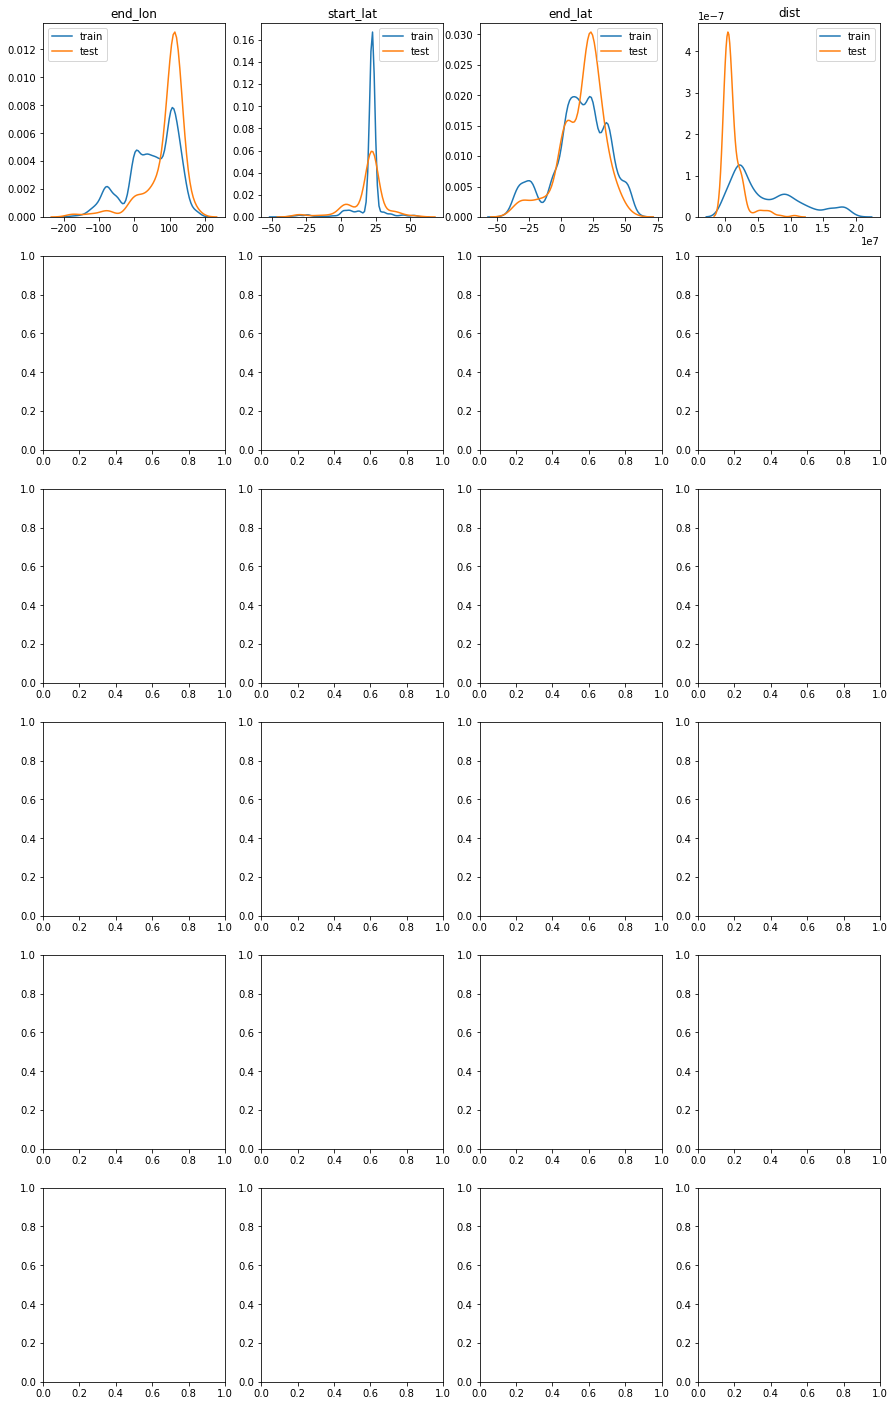

In [15]:
# 查看训练集与测试集特征分布
plt.subplots(6,4,figsize=(15,25))
for idx,col in enumerate(train.columns[9:-1]):
    plt.subplot(6,4,idx+1)
    plt.title(col)
    sns.kdeplot(train[col],label='train')
    sns.kdeplot(test[col],label='test')


In [16]:
features = [c for c in train.columns if c not in ['loadingOrder', 'label', 'mmin', 'mmax', 'count']]
#train=train[features]
print(features)

['TRANSPORT_TRACE', 'carrierName', 'vesselMMSI', 'start_lon', 'end_lon', 'start_lat', 'end_lat', 'dist', 'speed_mean']


In [17]:
def mse_score_eval(preds, valid):
    labels = valid.get_label()
    scores = mean_squared_error(y_true=labels/3600, y_pred=preds/3600)
    return 'mse_score', scores, False

def build_model(train, test, pred, label, seed=1080, is_shuffle=True):
    feature_importance_df = pd.DataFrame()
    train_pred = np.zeros((train.shape[0], ))
    test_pred = np.zeros((test.shape[0], ))
    n_splits = 5
    # Kfold
    fold = KFold(n_splits=n_splits, shuffle=is_shuffle, random_state=seed)
    kf_way = fold.split(train[pred])
    # params
    params = {
        'learning_rate': 0.01,
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'num_leaves': 36,
        'feature_fraction': 0.6,
        'bagging_fraction': 0.7,
        'bagging_freq': 6,
        'seed': 8,
        'bagging_seed': 1,
        'feature_fraction_seed': 7,
        'min_data_in_leaf': 20,
        'nthread': 8,
        'verbose': 1,
        'device':'cpu'
    }
    # train
    for n_fold, (train_idx, valid_idx) in enumerate(kf_way, start=1):
        train_x, train_y = train[pred].iloc[train_idx], train[label].iloc[train_idx]
        valid_x, valid_y = train[pred].iloc[valid_idx], train[label].iloc[valid_idx]
        # 数据加载
        n_train = lgb.Dataset(train_x, label=train_y)
        n_valid = lgb.Dataset(valid_x, label=valid_y)

        clf = lgb.train(
            params=params,
            train_set=n_train,
            num_boost_round=6000,
            valid_sets=[n_valid],
            early_stopping_rounds=100,
            verbose_eval=100,
            feval=mse_score_eval
        )
        train_pred[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration)
        test_pred += clf.predict(test[pred], num_iteration=clf.best_iteration)/fold.n_splits
        
        # 生成有feature和importance的特征重要度矩阵
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = pd.Series(features)
        fold_importance_df["importance"] = pd.Series(clf.feature_importance(importance_type='gain'))
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    
    # 打印特征重要度
    # best_features返回模型中平均重要度的降序排列
    best_features = (feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False))
    best_features['feature'] = best_features.index  # 因为这样操作后index是特征名，需要修改
    best_features.reset_index(drop=True)
    plt.figure(figsize=(14,20))
    sns.barplot(x="importance", y="feature", data=best_features)
    plt.title('LightGBM Features (averaged over folds)')
    plt.tight_layout()
    test['label'] = test_pred
    print('oof MSE: ',mean_squared_error(train[label]/3600,train_pred/3600))
    print('test_label均值',np.mean(test['label']/3600))
    print('train_label均值',np.mean(train['label']/3600))
    return test[['loadingOrder', 'label']]



Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.50024e+11	valid_0's mse_score: 19292
[200]	valid_0's l2: 1.14328e+11	valid_0's mse_score: 8821.63
[300]	valid_0's l2: 8.35012e+10	valid_0's mse_score: 6443
[400]	valid_0's l2: 7.37883e+10	valid_0's mse_score: 5693.54
[500]	valid_0's l2: 6.99299e+10	valid_0's mse_score: 5395.82
[600]	valid_0's l2: 6.77738e+10	valid_0's mse_score: 5229.46
[700]	valid_0's l2: 6.63262e+10	valid_0's mse_score: 5117.77
[800]	valid_0's l2: 6.54276e+10	valid_0's mse_score: 5048.43
[900]	valid_0's l2: 6.45813e+10	valid_0's mse_score: 4983.12
[1000]	valid_0's l2: 6.41773e+10	valid_0's mse_score: 4951.96
[1100]	valid_0's l2: 6.36657e+10	valid_0's mse_score: 4912.47
[1200]	valid_0's l2: 6.34563e+10	valid_0's mse_score: 4896.32
[1300]	valid_0's l2: 6.32773e+10	valid_0's mse_score: 4882.51
[1400]	valid_0's l2: 6.2969e+10	valid_0's mse_score: 4858.72
[1500]	valid_0's l2: 6.27279e+10	valid_0's mse_score: 4840.11
[1600]	valid_0's l2: 6.

oof MSE:  5176.9516801683185
test_label均值 103.9979805006858
train_label均值 368.9850202701316


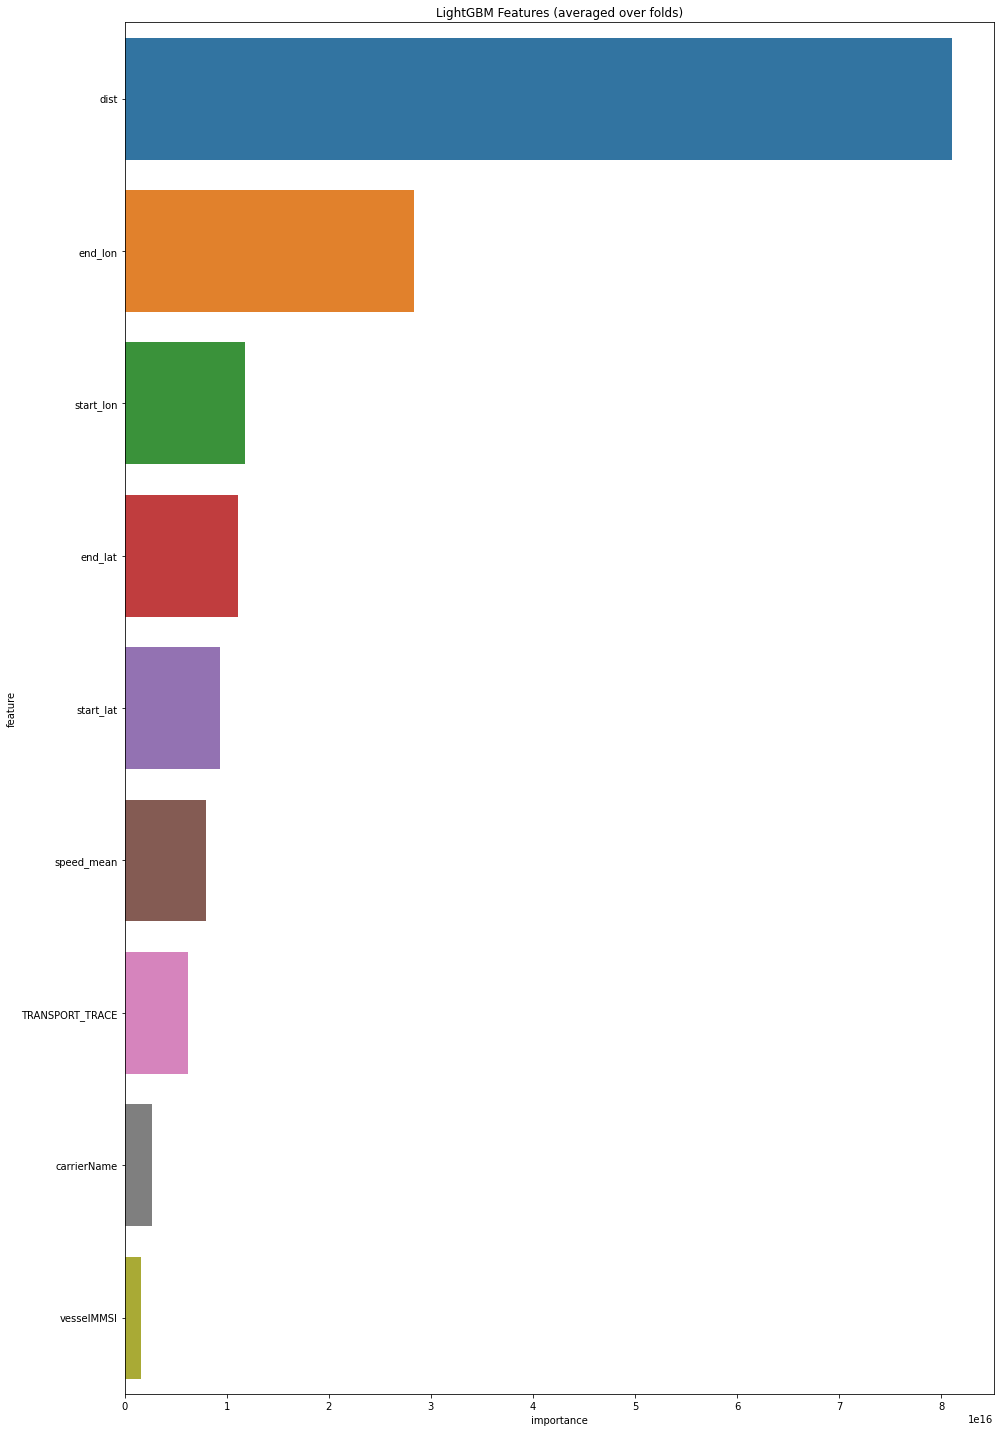

In [18]:
# baseline
result = build_model(train, test, features, 'label', is_shuffle=True)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.13089e+11	valid_0's mse_score: 8726.02
[200]	valid_0's l2: 3.50698e+10	valid_0's mse_score: 2706
[300]	valid_0's l2: 2.12797e+10	valid_0's mse_score: 1641.95
[400]	valid_0's l2: 1.77636e+10	valid_0's mse_score: 1370.64
[500]	valid_0's l2: 1.63963e+10	valid_0's mse_score: 1265.14
[600]	valid_0's l2: 1.55443e+10	valid_0's mse_score: 1199.41
[700]	valid_0's l2: 1.4802e+10	valid_0's mse_score: 1142.13
[800]	valid_0's l2: 1.4285e+10	valid_0's mse_score: 1102.24
[900]	valid_0's l2: 1.43666e+10	valid_0's mse_score: 1108.53
Early stopping, best iteration is:
[802]	valid_0's l2: 1.42824e+10	valid_0's mse_score: 1102.04
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.06998e+11	valid_0's mse_score: 8255.99
[200]	valid_0's l2: 2.93358e+10	valid_0's mse_score: 2263.56
[300]	valid_0's l2: 1.28281e+10	valid_0's mse_score: 989.819
[400]	valid_0's l2: 8.07142e+09	valid_0's mse_score: 

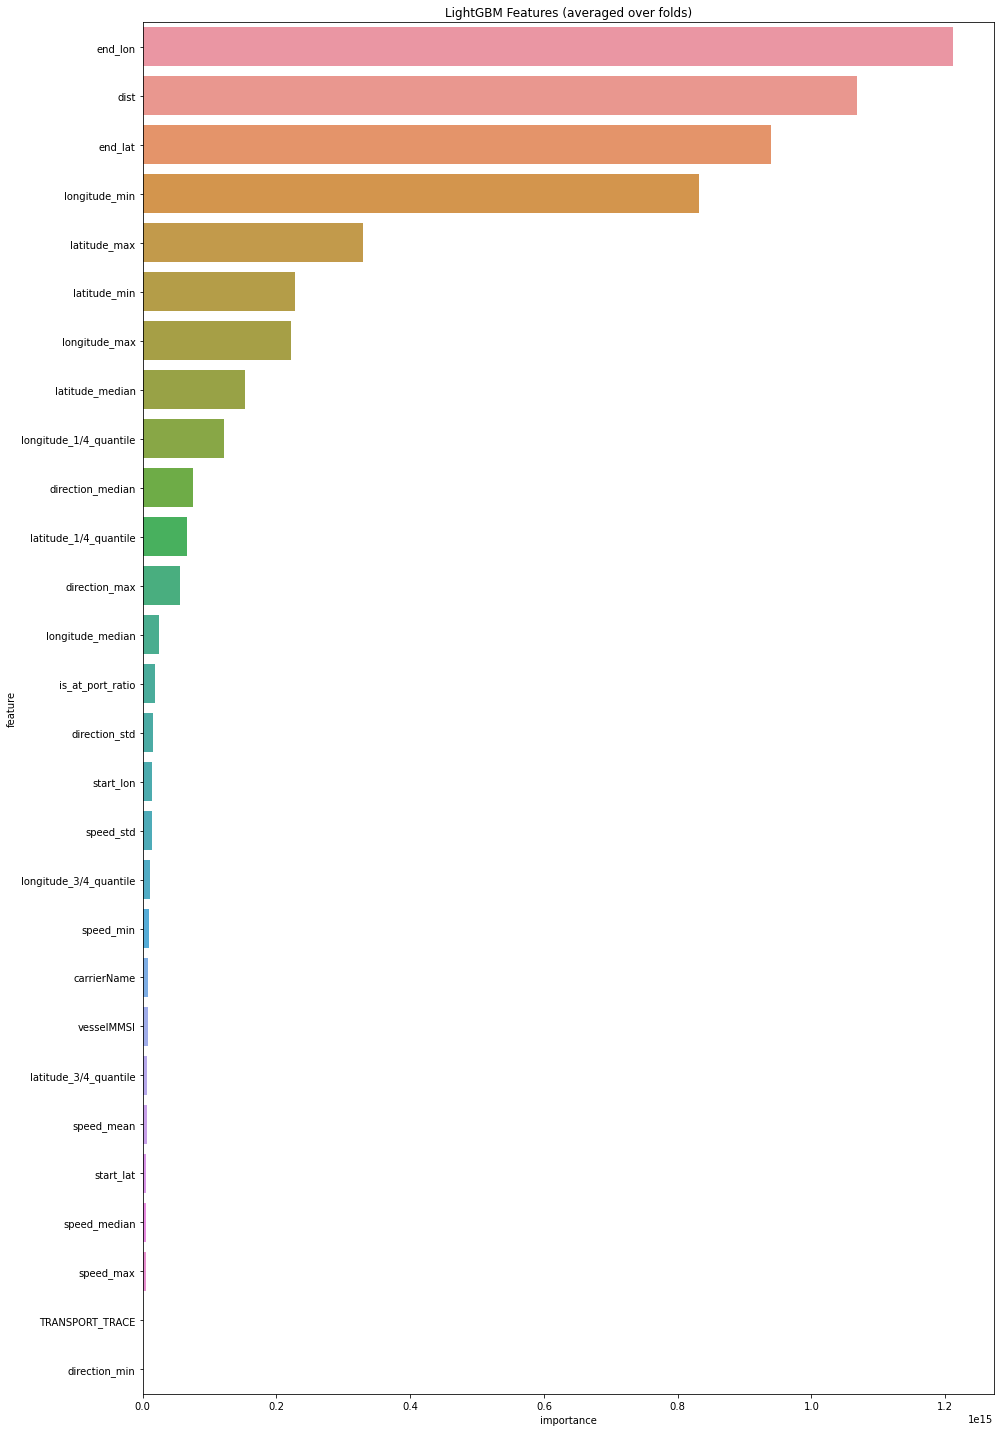

In [172]:
# 统计
result = build_model(train, test, features, 'label', is_shuffle=True)

In [19]:
result_data= pd.read_csv('data/R2 ATest 0711.csv')
result_data = result_data.merge(result, on='loadingOrder', how='left')
result_data = get_data(result_data, mode='test')  # 转换格式
result_data['ETA'] = (result_data['onboardDate'] + result_data['label'].apply(lambda x:pd.Timedelta(seconds=x))).apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
result_data.drop(['direction','TRANSPORT_TRACE'],axis=1,inplace=True)
result_data['onboardDate'] = result_data['onboardDate'].apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
result_data['creatDate'] = pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')
result_data['timestamp'] = result_data['temp_timestamp']
# 整理columns顺序
result = result_data[['loadingOrder', 'timestamp', 'longitude', 'latitude', 'carrierName', 'vesselMMSI', 'onboardDate', 'ETA', 'creatDate']]

d:\tools\python\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


In [20]:
# 计算label分布
def cal_label(best):
    onboardDate = best.groupby('loadingOrder')['onboardDate'].agg(mmax='max').reset_index()
    ETA=best.groupby('loadingOrder')['ETA'].agg(mmax='max').reset_index()
    return (pd.to_datetime(ETA['mmax'])-pd.to_datetime(onboardDate['mmax'])).dt.total_seconds()

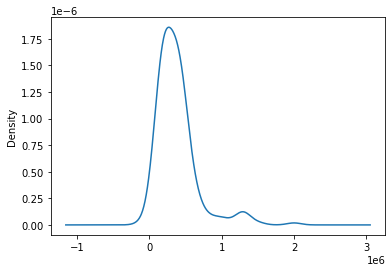

In [21]:
# baseline
new=cal_label(result)
new.plot(kind='kde')
plt.show()

In [22]:
import datetime
now = datetime.datetime.now()
result.to_csv('result/result_{0}-{1}-{2}_{3}-{4}.csv'.format(now.year,now.month,now.day,now.hour,now.minute), index=False)

In [176]:
result

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
0,AE223035353902,2019-07-03T21:16:48.000Z,120.093858,22.581320,OIEQNT,C2075927370,2019/07/02 04:12:48,2019/07/13 06:28:54,2020/06/27 22:32:21
1,AE223035353902,2019-07-03T21:34:48.000Z,120.035707,22.617522,OIEQNT,C2075927370,2019/07/02 04:12:48,2019/07/13 06:28:54,2020/06/27 22:32:21
2,AE223035353902,2019-07-03T21:51:18.000Z,119.981800,22.658465,OIEQNT,C2075927370,2019/07/02 04:12:48,2019/07/13 06:28:54,2020/06/27 22:32:21
3,AE223035353902,2019-07-03T21:54:18.000Z,119.970845,22.668688,OIEQNT,C2075927370,2019/07/02 04:12:48,2019/07/13 06:28:54,2020/06/27 22:32:21
4,AE223035353902,2019-07-03T22:11:08.000Z,119.953628,22.756897,OIEQNT,C2075927370,2019/07/02 04:12:48,2019/07/13 06:28:54,2020/06/27 22:32:21
...,...,...,...,...,...,...,...,...,...
34707,ZZ524449869421,2020-03-17T04:02:38.000Z,103.776707,1.252897,BHSOUA,P2595193878,2020/03/13 06:07:28,2020/03/18 13:29:07,2020/06/27 22:32:21
34708,ZZ524449869421,2020-03-17T04:03:18.000Z,103.776312,1.253418,BHSOUA,P2595193878,2020/03/13 06:07:28,2020/03/18 13:29:07,2020/06/27 22:32:21
34709,ZZ524449869421,2020-03-17T04:05:18.000Z,103.775175,1.254865,BHSOUA,P2595193878,2020/03/13 06:07:28,2020/03/18 13:29:07,2020/06/27 22:32:21
34710,ZZ524449869421,2020-03-17T04:05:58.000Z,103.774803,1.255285,BHSOUA,P2595193878,2020/03/13 06:07:28,2020/03/18 13:29:07,2020/06/27 22:32:21


In [178]:
pd.read_csv('data/testData 0626.csv')

,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE
0,AE223035353902,2019-07-03T21:16:48.000Z,120.093858,22.581320,24,29070.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO
1,AE223035353902,2019-07-03T21:34:48.000Z,120.035707,22.617522,25,34550.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO
2,AE223035353902,2019-07-03T21:51:18.000Z,119.981800,22.658465,32,30160.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO
3,AE223035353902,2019-07-03T21:54:18.000Z,119.970845,22.668688,33,33540.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO
4,AE223035353902,2019-07-03T22:11:08.000Z,119.953628,22.756897,36,35140.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO
...,...,...,...,...,...,...,...,...,...,...
34707,ZZ524449869421,2020-03-17T04:02:38.000Z,103.776707,1.252897,6,32320.0,BHSOUA,P2595193878,2020/03/13 06:07:28,CNSHK-GRPIR
34708,ZZ524449869421,2020-03-17T04:03:18.000Z,103.776312,1.253418,6,32340.0,BHSOUA,P2595193878,2020/03/13 06:07:28,CNSHK-GRPIR
34709,ZZ524449869421,2020-03-17T04:05:18.000Z,103.775175,1.254865,5,32030.0,BHSOUA,P2595193878,2020/03/13 06:07:28,CNSHK-GRPIR
34710,ZZ524449869421,2020-03-17T04:05:58.000Z,103.774803,1.255285,5,31940.0,BHSOUA,P2595193878,2020/03/13 06:07:28,CNSHK-GRPIR
